In [1]:
from firedrake import (
    RectangleMesh,
    FunctionSpace,
    Function,
    SpatialCoordinate,
    conditional,
    File,
)

In [2]:
from firedrake import *
# from firedrake_adjoint import *
import spyro
import numpy as np
import math
import numpy                  as np
import matplotlib.pyplot      as plot
import matplotlib.ticker      as mticker  
from matplotlib               import cm, ticker
from mpl_toolkits.axes_grid1  import make_axes_locatable

In [3]:
from __future__ import print_function
from firedrake import *
from firedrake_adjoint import *
import numpy as np
import os, sys
import spyro
import numpy as np
import math
import matplotlib.pyplot as plot
import matplotlib.ticker      as mticker  
from matplotlib               import cm
from mpl_toolkits.axes_grid1  import make_axes_locatable

model = {}

# Choose method and parameters
model["opts"] = {
    "method": "KMV",  # either CG or KMV
    "quadratrue": "KMV", # Equi or KMV
    "degree": 1,  # p order
    "dimension": 2,  # dimension
}

# Number of cores for the shot. For simplicity, we keep things serial.
# spyro however supports both spatial parallelism and "shot" parallelism.
model["parallelism"] = {
    "type": "automatic",  # options: automatic (same number of cores for evey processor), custom, off.
    "custom_cores_per_shot": [],  # only if the user wants a different number of cores for every shot.
    "num_cores_per_shot": 1
    # input is a list of integers with the length of the number of shots.
}

# Define the domain size without the PML. Here we'll assume a 0.75 x 1.50 km
# domain and reserve the remaining 250 m for the Perfectly Matched Layer (PML) to absorb
# outgoing waves on three sides (eg., -z, +-x sides) of the domain.
model["mesh"] = {
    "Lz": 0.75,  # depth in km - always positive
    "Lx": 1.5,  # width in km - always positive
    "Ly": 0.0,  # thickness in km - always positive
    "meshfile": "not_used.msh",
    "initmodel": "not_used.hdf5",
    "truemodel": "not_used.hdf5",
}

model["BCs"] = {
    "status": True,  # True or false
    "outer_bc": "non-reflective",  #  neumann, non-reflective (outer boundary condition)
    "damping_type": "polynomial",  # polynomial. hyperbolic, shifted_hyperbolic
    "exponent": 1,
    "cmax": 4.7,  # maximum acoustic wave velocity in PML - km/s
    "R": 0.001,  # theoretical reflection coefficient
    "lz": 0.05,  # thickness of the pml in the z-direction (km) - always positive
    "lx": 0.05,  # thickness of the pml in the x-direction (km) - always positive
    "ly": 0.0,  # thickness of the pml in the y-direction (km) - always positive
}

# Create a source injection operator. Here we use a single source with a
# Ricker wavelet that has a peak frequency of 8 Hz injected at the center of the mesh.
# We also specify to record the solution at 101 microphones near the top of the domain.
# This transect of receivers is created with the helper function `create_transect`.
model["acquisition"] = {
    "source_type": "Ricker",
    "num_sources": 1,
    "source_pos": [(0.1, 0.5)],
    "frequency": 3.0,
    "delay": 1.0,
    "num_receivers": 100,
    "receiver_locations": spyro.create_transect(
        (0.10, 0.1), (0.10, 0.9), 100
    ),
}

# Simulate for 2.0 seconds.
model["timeaxis"] = {
    "t0": 0.0,  #  Initial time for event
    "tf": 1.00,  # Final time for event
    "dt": 0.001,  # timestep size
    "amplitude": 1,  # the Ricker has an amplitude of 1.
    "nspool": 100,  # how frequently to output solution to pvds
    "fspool": 100,  # how frequently to save solution to RAM
}

num_rec = model["acquisition"]["num_receivers"]
δs = np.linspace(0.1, 0.9, num_rec)
X, Y = np.meshgrid(0.1, δs)
xs = np.vstack((X.flatten(), Y.flatten())).T


In [4]:
mesh = RectangleMesh(100, 100, 1.0, 1.0)
# V    = FunctionSpace(mesh, family='CG', degree=2)
# Create the computational environment
comm = spyro.utils.mpi_init(model)

element = spyro.domains.space.FE_method(
    mesh, model["opts"]["method"], model["opts"]["degree"]
)
V = FunctionSpace(mesh, element)


In [5]:
x, y = SpatialCoordinate(mesh)
velocity = conditional(x > 0.35, 1.5, 1.5)

vp = Function(V, name="vp").interpolate(velocity)


In [6]:
sources = spyro.Sources(model, mesh, V, comm).create()

receivers = spyro.Receivers(model, mesh, V, comm).create()

wavelet = spyro.full_ricker_wavelet(dt=0.001, tf=3.0, freq=10.0)


In [7]:
solver         = spyro.solvers.forward
usol, usol_rec = solver(model, mesh, comm, vp, sources, wavelet, receivers, source_num=0)

Simulation time is:      0.099 seconds
Simulation time is:      0.199 seconds
Simulation time is:      0.299 seconds
Simulation time is:      0.399 seconds
Simulation time is:      0.499 seconds
Simulation time is:      0.599 seconds
Simulation time is:      0.699 seconds
Simulation time is:      0.799 seconds
Simulation time is:      0.899 seconds


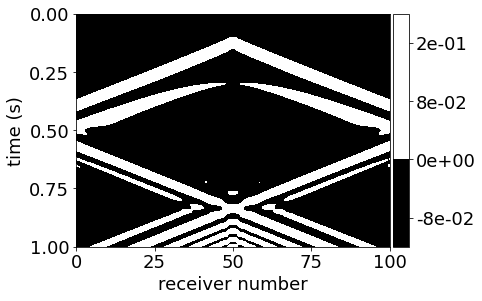

In [8]:
spyro.plots.plot_shotrecords(
            model, usol_rec, appear=True, name=str(0 + 1), save=False,legend=True
        )

In [9]:
misfit = usol_rec

J_total = spyro.utils.compute_functional(model,misfit)


In [10]:
dJ = spyro.solvers.gradient(
                        model,mesh,comm,vp, receivers,usol,misfit)


NameError: name 'x' is not defined

In [ ]:
from mpi4py import MPI
# sum over all ensemble members
dJ.dat.data[:] = comm.ensemble_comm.allreduce(
    dJ.dat.data[:], op=MPI.SUM
)


fig, axes = plot.subplots()
axes.set_aspect('equal')
colors = firedrake.tripcolor(dJ, axes=axes, shading='gouraud', cmap="jet")

fig.colorbar(colors);
plot.savefig('grad.png',dpi=100,format='png')